In [38]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import chi2
import warnings

class PartialCI:
    def __init__(self):
        self.params = {}
        self.results = {}
        self.fitted_model = None

    def _kalman_filter(self, y, X, beta, rho, sigma_M, sigma_R, return_states=False):
        """
        Core Kalman Filter logic.
        Models spread W_t = Y_t - beta*X_t as sum of AR(1) M_t and RW R_t.
        """
        n = len(y)
        # Construct Spread
        if X is not None:
            # Ensure beta is array-like for dot product
            W = y - (X @ beta)
        else:
            W = y # Case where we model a single series directly

        # State Vector Z = [M, R]
        Z = np.zeros(2) 
        # Covariance P (Initialize with steady state approx)
        P = np.diag([sigma_M**2 / (1 - rho**2 + 1e-6), sigma_R**2 * 10])

        # Transition Matrix F
        F = np.array([[rho, 0], [0, 1]])
        # Observation Matrix H
        H = np.array([1, 1])
        # Process Noise Q
        Q = np.diag([sigma_M**2, sigma_R**2])

        log_likelihood = 0.0
        
        # Containers for state history
        M_states = np.zeros(n)
        R_states = np.zeros(n)

        for t in range(n):
            # 1. Predict
            Z_pred = F @ Z
            P_pred = F @ P @ F.T + Q

            # 2. Update
            innovation = W[t] - H @ Z_pred
            S = H @ P_pred @ H.T  # Innovation Covariance
            
            # Numeric stability
            if S < 1e-9: S = 1e-9

            # Log Likelihood accumulation (ignoring constants)
            log_likelihood += -0.5 * (np.log(S) + (innovation**2) / S)

            # Kalman Gain
            K = P_pred @ H.T / S

            # Update State
            Z = Z_pred + K * innovation
            P = (np.eye(2) - np.outer(K, H)) @ P_pred
            
            if return_states:
                M_states[t] = Z[0]
                R_states[t] = Z[1]

        if return_states:
            return M_states, R_states
        return -log_likelihood  # Return NLL for minimization

    # --- 1. fit.pci Implementation ---
    def fit(self, Y, X):
        """
        Corresponds to fit.pci(). Estimating parameters via Maximum Likelihood.
        """
        # Convert to numpy
        Y = np.array(Y)
        X = np.array(X)
        if X.ndim == 1: X = X.reshape(-1, 1)
        
        k = X.shape[1] # Number of factors

        # Initial Guess via OLS
        beta_init = np.linalg.lstsq(X, Y, rcond=None)[0]
        res = Y - X @ beta_init
        std_res = np.std(res)
        
        # Param structure: [beta_1...beta_k, rho, sigma_M, sigma_R]
        init_params = np.concatenate([beta_init, [0.5, std_res*0.5, std_res*0.5]])
        
        # Bounds: Beta (free), rho (-0.999, 0.999), sigmas (>0)
        bounds = [(None, None)]*k + [(-0.999, 0.999), (1e-5, None), (1e-5, None)]

        def objective(params):
            b = params[:k]
            r = params[k]
            sM = params[k+1]
            sR = params[k+2]
            return self._kalman_filter(Y, X, b, r, sM, sR)

        opt = minimize(objective, init_params, bounds=bounds, method='L-BFGS-B')
        
        # Store Results
        self.params['beta'] = opt.x[:k]
        self.params['rho'] = opt.x[k]
        self.params['sigma_M'] = opt.x[k+1]
        self.params['sigma_R'] = opt.x[k+2]
        self.params['neg_ll'] = opt.fun
        
        # Calculate PVMR
        var_mr = (2 * self.params['sigma_M']**2) / (1 + self.params['rho'])
        var_tot = var_mr + self.params['sigma_R']**2
        self.params['pvmr'] = var_mr / var_tot if var_tot > 0 else 0
        
        self.fitted_model = {'Y': Y, 'X': X} # Save data for state history
        return self.params

    # --- 2. test.pci Implementation ---
    def test(self, Y, X, alpha=0.05):
        """
        Corresponds to test.pci(). Performs Likelihood Ratio Tests.
        """
        # --- FIX: Ensure X is 2D before accessing shape ---
        Y = np.array(Y)
        X = np.array(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        # --------------------------------------------------

        # 1. Fit Full Model
        self.fit(Y, X)
        ll_full = -self.params['neg_ll'] # Negate back to Log Likelihood
        
        k = X.shape[1] # Now this will safely return 1
        
        # 2. Fit Null: Random Walk (rho=0, sigma_M=0)
        def obj_rw(params):
            b = params[:k]
            sR = params[k]
            # Force rho=0, sigma_M=0
            return self._kalman_filter(Y, X, b, 0, 0, sR)
            
        beta_init = self.params['beta']
        # We need a safe initial guess for sigma_R. Use the fitted one or a small fallback.
        sig_r_init = self.params['sigma_R'] if self.params['sigma_R'] > 1e-5 else 0.01
        
        init_rw = np.concatenate([beta_init, [sig_r_init]])
        bounds_rw = [(None, None)]*k + [(1e-5, None)]
        
        opt_rw = minimize(obj_rw, init_rw, bounds=bounds_rw, method='L-BFGS-B')
        ll_rw = -opt_rw.fun
        
        # 3. Fit Null: AR(1) (sigma_R=0)
        def obj_ar(params):
            b = params[:k]
            r = params[k]
            sM = params[k+1]
            # Force sigma_R=0
            return self._kalman_filter(Y, X, b, r, sM, 0)
            
        # Safe initial guesses
        rho_init = self.params['rho']
        sig_m_init = self.params['sigma_M'] if self.params['sigma_M'] > 1e-5 else 0.01

        init_ar = np.concatenate([beta_init, [rho_init, sig_m_init]])
        bounds_ar = [(None, None)]*k + [(-0.999, 0.999), (1e-5, None)]
        
        opt_ar = minimize(obj_ar, init_ar, bounds=bounds_ar, method='L-BFGS-B')
        ll_ar = -opt_ar.fun

        # 4. Compute Test Statistics (Likelihood Ratio)
        # LR = 2 * (LL_unrestricted - LL_restricted)
        # Numerical safety: prevent negative LR due to tiny optimization differences
        stat_rw = max(0, 2 * (ll_full - ll_rw))
        stat_ar = max(0, 2 * (ll_full - ll_ar))
        
        # P-values (Chi-Squared with 1 dof)
        pval_rw = 1 - chi2.cdf(stat_rw, df=1)
        pval_ar = 1 - chi2.cdf(stat_ar, df=1)
        
        is_pci = (pval_rw < alpha) and (pval_ar < alpha)
        
        return {
            "stat_rw": stat_rw, "pval_rw": pval_rw,
            "stat_ar": stat_ar, "pval_ar": pval_ar,
            "is_partially_cointegrated": is_pci
        }

    # --- 3. statehistory.pci Implementation ---
    def state_history(self):
        """
        Corresponds to statehistory.pci(). Extracts M_t and R_t.
        """
        if self.fitted_model is None:
            raise ValueError("Must run fit() first.")
            
        Y = self.fitted_model['Y']
        X = self.fitted_model['X']
        p = self.params
        
        M, R = self._kalman_filter(Y, X, p['beta'], p['rho'], 
                                   p['sigma_M'], p['sigma_R'], return_states=True)
        return pd.DataFrame({'M': M, 'R': R}, index=range(len(M)))

    # --- 4. hedge.pci Implementation ---
    def hedge(self, target_series, candidate_df):
        """
        Corresponds to hedge.pci(). Finds best factor subset.
        Simple 'full' search implementation (forward selection).
        """
        target = np.array(target_series)
        candidates = candidate_df.values
        col_names = candidate_df.columns
        n_candidates = candidates.shape[1]
        
        best_ll = -np.inf
        best_col_idx = -1
        best_model_params = None
        
        results_log = []

        # Iterate through each candidate to find the best single factor
        print(f"Searching best hedge among {n_candidates} candidates...")
        for i in range(n_candidates):
            X_subset = candidates[:, i].reshape(-1, 1)
            
            # Fit model
            current_model = PartialCI()
            params = current_model.fit(target, X_subset)
            ll = -params['neg_ll']
            
            results_log.append({
                'factor': col_names[i],
                'll': ll,
                'pvmr': params['pvmr']
            })
            
            if ll > best_ll:
                best_ll = ll
                best_col_idx = i
                best_model_params = params
        
        best_factor_name = col_names[best_col_idx]
        print(f"Best single factor found: {best_factor_name} (LL: {best_ll:.2f})")
        
        return {
            "best_factor": best_factor_name,
            "best_params": best_model_params,
            "all_results": pd.DataFrame(results_log).sort_values('ll', ascending=False)
        }



In [ ]:
# Generate Synthetic Data for Testing
np.random.seed(42)
n = 200

# 1. Create a Factor (e.g., SPY)
X_factor = np.cumsum(np.random.normal(0, 1, n))

# 2. Create Target (e.g., Sector ETF) with PCI properties
# Target = 1.5*Factor + MeanReversion + RandomWalkDrift
M_true = np.zeros(n)
R_true = np.zeros(n)
rho_true = 0.8

for t in range(1, n):
    M_true[t] = rho_true * M_true[t-1] + np.random.normal(0, 0.5) # AR(1)
    R_true[t] = R_true[t-1] + np.random.normal(0, 0.1)            # RW
    
Y_target = 1.5 * X_factor + M_true + R_true

# --- Step 1: Initialize and Fit ---
pci = PartialCI()
print("Fitting PCI Model...")
params = pci.fit(Y_target, X_factor)
print("Fitted Parameters:", params)

# --- Step 2: Test for Cointegration ---
print("\nTesting for Partial Cointegration...")
test_res = pci.test(Y_target, X_factor)
print(test_res)

# --- Step 3: Extract States ---
print("\nExtracting Hidden States...")
states = pci.state_history()
print(states.head())

# --- Step 4: Hedge Search (Mock Example) ---
# Create dummy candidate dataframe
df_candidates = pd.DataFrame({
    'Factor_A': X_factor,              # The true factor
    'Factor_B': np.random.normal(0,1,n).cumsum(), # Random factor
    'Factor_C': X_factor + np.random.normal(0,5,n) # Noisy factor
})

print("\nRunning Hedge Search...")
hedge_res = pci.hedge(Y_target, df_candidates)
print("Best Hedge Factor:", hedge_res['best_factor'])

Fitting PCI Model...
Fitted Parameters: {'beta': array([1.5126]), 'rho': np.float64(0.75429657473041), 'sigma_M': np.float64(0.5144255581199608), 'sigma_R': np.float64(0.07757348429592734), 'neg_ll': np.float64(-27.26677048857456), 'pvmr': np.float64(0.9804441189018401)}

Testing for Partial Cointegration...
{'stat_rw': np.float64(19.945904147584343), 'pval_rw': np.float64(7.966443077100926e-06), 'stat_ar': np.float64(1.0061546625770887), 'pval_ar': np.float64(0.3158258285572262), 'is_partially_cointegrated': np.False_}

Extracting Hidden States...
          M         R
0 -0.005632 -0.000607
1  0.213316  0.017153
2  0.764277  0.069183
3 -0.111967  0.006750
4  0.200982  0.033864

Running Hedge Search...
Searching best hedge among 3 candidates...
Best single factor found: Factor_A (LL: 27.27)
Best Hedge Factor: Factor_A


In [ ]:
# 1. Prepare your data
# Ensure they are the same length and no NaNs
my_target = [100, 101, 102, ...] # Your "Y" series
my_factor = [50, 51, 52, ...]    # Your "X" series

# 2. Initialize the class
model = PartialCI()

# 3. Fit the model
results = model.fit(my_target, my_factor)
print("Hedge Ratio (Beta):", results['beta'])
print("Mean Reversion Speed (Rho):", results['rho'])

# 4. Check if it's actually cointegrated
test_results = model.test(my_target, my_factor)
if test_results['is_partially_cointegrated']:
    print("Success! These series are partially cointegrated.")
    
    # 5. Get the trading signals
    history = model.state_history()
    
    # Plot the Mean Reverting component (The Signal)
    import matplotlib.pyplot as plt
    plt.plot(history['M'])
    plt.title("Trading Signal (M_t)")
    plt.show()
else:
    print("These series are likely just a Random Walk. Do not trade.")

Data loaded. 1259 daily observations.

Fitting Partial Cointegration Model...

--- Model Results ---
Hedge Ratio (Beta): 0.9950
Mean Rev Speed (Rho): 0.6956
PVMR (Signal Strength): 0.6692

Running Likelihood Ratio Test...
✅ SUCCESS: The pair is Partially Cointegrated.
Random Walk P-Value: 0.00000 (Should be < 0.05)
AR(1) P-Value:       0.00005 (Should be < 0.05)


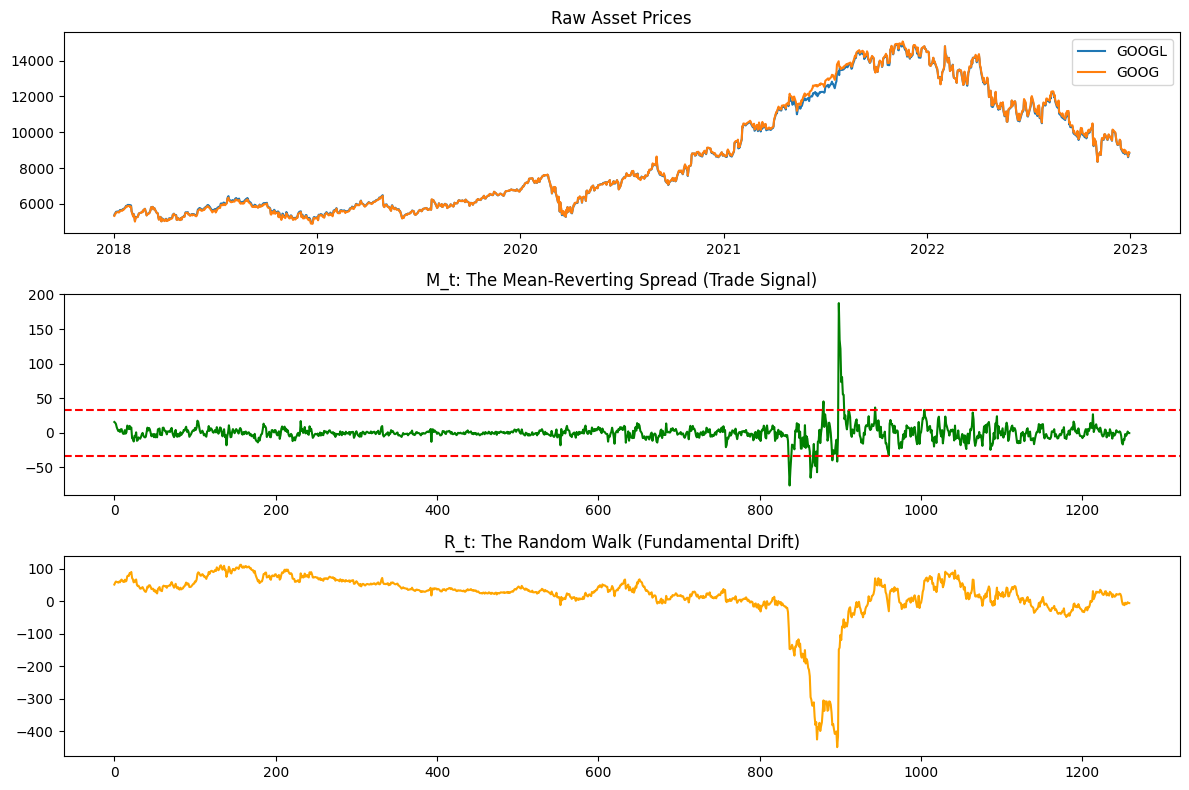

In [34]:

# Align the series
# GOOGL (Class A) = Target
# GOOG (Class C) = Factor
Y = data['Close'][tickers[0]] * 100
X = data['Close'][tickers[1]] * 100

print(f"Data loaded. {len(Y)} daily observations.")

# --- Step 2: Fit the Model ---
model = PartialCI()
print("\nFitting Partial Cointegration Model...")
params = model.fit(Y, X)

print("\n--- Model Results ---")
print(f"Hedge Ratio (Beta): {params['beta'][0]:.4f}")
print(f"Mean Rev Speed (Rho): {params['rho']:.4f}")
print(f"PVMR (Signal Strength): {params['pvmr']:.4f}")
# PVMR interpretation: 
# > 0.5 means the spread is mostly mean-reverting (Good for trading)
# < 0.2 means the spread is mostly random walk (Bad for trading)

# --- Step 3: Run the Statistical Test ---
print("\nRunning Likelihood Ratio Test...")
test_res = model.test(Y, X)

if test_res['is_partially_cointegrated']:
    print("✅ SUCCESS: The pair is Partially Cointegrated.")
    print(f"Random Walk P-Value: {test_res['pval_rw']:.5f} (Should be < 0.05)")
    print(f"AR(1) P-Value:       {test_res['pval_ar']:.5f} (Should be < 0.05)")
else:
    print("❌ FAIL: The pair is not cointegrated.")

# --- Step 4: Visualize the Hidden States ---
history = model.state_history()

plt.figure(figsize=(12, 8))

# 1. Prices
plt.subplot(3, 1, 1)
plt.plot(Y, label=tickers[0])
plt.plot(X, label=tickers[1])
plt.title('Raw Asset Prices')
plt.legend()

# 2. Mean Reversion Component (The Signal)
plt.subplot(3, 1, 2)
plt.plot(history['M'], color='green')
plt.axhline(2 * params['sigma_M'], color='red', linestyle='--')
plt.axhline(-2 * params['sigma_M'], color='red', linestyle='--')
plt.title('M_t: The Mean-Reverting Spread (Trade Signal)')

# 3. Random Walk Component (The Noise)
plt.subplot(3, 1, 3)
plt.plot(history['R'], color='orange')
plt.title('R_t: The Random Walk (Fundamental Drift)')

plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
import requests

# 1. Define the URL

url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# 2. Define a User-Agent header to mimic a web browser
# This is the key to bypassing the 403 Forbidden error
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

try:
    # 3. Use requests to fetch the content with the header
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Check for HTTP errors (like 404, 500, etc.)

    # 4. Pass the fetched HTML content to pandas.read_html
    # We select the first table (index 0), which contains the list
    sp500_table = pd.read_html(response.text, header=0)[0]

    # 5. Extract the 'Symbol' column
    symbols_list = sp500_table['Symbol'].tolist()

    print(symbols_list)
    
except requests.exceptions.HTTPError as e:
    print(f"❌ HTTP Error: {e}")
    print("The server rejected the request. Try a different User-Agent string.")
except Exception as e:
    print(f"❌ An error occurred: {e}")

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APP', 'APTV', 'ACGL', 'ADM', 'ARES', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'XYZ', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CPT', 'CPB', 'COF', 'CAH', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'COIN', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DDOG', 

C:\Users\William\AppData\Local\Temp\ipykernel_3292\860126731.py:21: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sp500_table = pd.read_html(response.text, header=0)[0]


In [61]:
columns = ["symbol"]
df = pd.DataFrame(symbols_list, columns=columns)
df.to_csv("sp500_symbols.csv", index=False)

In [5]:
import yfinance as yf
data = yf.download(symbols_list, start='2020-01-01', end='2025-12-12')

data.isna()


C:\Users\William\AppData\Local\Temp\ipykernel_3292\3648767699.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbols_list, start='2020-01-01', end='2025-12-12')
[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2025-12-12)')


Price      Adj Close        Close                                            \
Ticker          BF.B BRK.B      A   AAPL   ABBV   ABNB    ABT   ACGL    ACN   
Date                                                                          
2020-01-02      True  True  False  False  False   True  False  False  False   
2020-01-03      True  True  False  False  False   True  False  False  False   
2020-01-06      True  True  False  False  False   True  False  False  False   
2020-01-07      True  True  False  False  False   True  False  False  False   
2020-01-08      True  True  False  False  False   True  False  False  False   
...              ...   ...    ...    ...    ...    ...    ...    ...    ...   
2025-12-05      True  True  False  False  False  False  False  False  False   
2025-12-08      True  True  False  False  False  False  False  False  False   
2025-12-09      True  True  False  False  False  False  False  False  False   
2025-12-10      True  True  False  False  False  False  False  False  False   
2025-12-11      True  True  False  False  False  False  False  False  False   

Price              ... Volume                                            \
Ticker       ADBE  ...     WY   WYNN    XEL    XOM    XYL    XYZ    YUM   
Date               ...                                                    
2020-01-02  False  ...  False  False  False  False  False  False  False   
2020-01-03  False  ...  False  False  False  False  False  False  False   
2020-01-06  False  ...  False  False  False  False  False  False  False   
2020-01-07  False  ...  False  False  False  False  False  False  False   
2020-01-08  False  ...  False  False  False  False  False  False  False   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
2025-12-05  False  ...  False  False  False  False  False  False  False   
2025-12-08  False  ...  False  False  False  False  False  False  False   
2025-12-09  False  ...  False  False  False  False  False  False  False   
2025-12-10  False  ...  False  False  False  False  False  False  False   
2025-12-11  False  ...  False  False  False  False  False  False  False   

Price                            
Ticker        ZBH   ZBRA    ZTS  
Date                             
2020-01-02  False  False  False  
2020-01-03  False  False  False  
2020-01-06  False  False  False  
2020-01-07  False  False  False  
2020-01-08  False  False  False  
...           ...    ...    ...  
2025-12-05  False  False  False  
2025-12-08  False  False  False  
2025-12-09  False  False  False  
2025-12-10  False  False  False  
2025-12-11  False  False  False  

[1495 rows x 2517 columns]

In [24]:
cleaned_df

Price            Close                                                 \
Ticker               A        AAPL        ABBV         ABT       ACGL   
Date                                                                    
2020-01-02   82.545311   72.468246   69.823479   78.208054  41.268997   
2020-01-03   81.219971   71.763725   69.160683   77.254623  41.221451   
2020-01-06   81.460075   72.335556   69.706512   77.659348  41.383106   
2020-01-07   81.709747   71.995346   69.308838   77.227623  41.040779   
2020-01-08   82.516502   73.153511   69.800064   77.542458  40.631893   
...                ...         ...         ...         ...        ...   
2025-12-05  145.490005  278.779999  226.080002  125.080002  91.720001   
2025-12-08  142.440002  277.890015  223.119995  122.089996  90.940002   
2025-12-09  140.639999  277.179993  222.990005  121.250000  91.919998   
2025-12-10  143.470001  278.779999  225.179993  122.550003  91.769997   
2025-12-11  142.869995  278.029999  223.979996  123.279999  93.639999   

Price                                                                  ...  \
Ticker             ACN        ADBE         ADI        ADM         ADP  ...   
Date                                                                   ...   
2020-01-02  192.514999  334.429993  108.129173  38.799721  150.852676  ...   
2020-01-03  192.194397  331.809998  106.225700  38.723991  150.533844  ...   
2020-01-06  190.939362  333.709991  104.977692  38.421066  150.737518  ...   
2020-01-07  186.816925  333.390015  107.365990  37.958252  148.912949  ...   
2020-01-08  187.183395  337.869995  108.335686  37.537533  150.312378  ...   
...                ...         ...         ...        ...         ...  ...   
2025-12-05  266.589996  346.260010  280.300018  59.009998  261.630005  ...   
2025-12-08  266.500000  339.119995  279.130005  57.939999  258.690002  ...   
2025-12-09  269.529999  344.320007  276.239990  58.070000  258.230011  ...   
2025-12-10  272.220001  343.130005  281.570007  58.209999  259.339996  ...   
2025-12-11  270.369995  350.429993  283.390015  59.919998  264.690002  ...   

Price         Volume                                                          \
Ticker            WY     WYNN      XEL       XOM      XYL       XYZ      YUM   
Date                                                                           
2020-01-02   4973500  3006500  2915400  12456400   869500   5264700  1369900   
2020-01-03   3111000  1760500  2422500  17386900   795100   5087100  1145500   
2020-01-06   2178600  1357900  2217100  20081900   817300   5905200  1454100   
2020-01-07   2426200  1722100  1861100  17387700   662200  10368200  1388600   
2020-01-08   2299800  1176200  4828900  15137700  1083200  11899200  1521500   
...              ...      ...      ...       ...      ...       ...      ...   
2025-12-05   7305600   856000  3563000  12516900  1569300   6670900  2503200   
2025-12-08  11331600  1816500  3197700  14904200  1725000   6154300  1822600   
2025-12-09   7622300  1400500  4842400  23790800  1334700   5118000  1582800   
2025-12-10   9505100  1122200  4824700  19845200  1381100   5491000  2506500   
2025-12-11   8716800  1193900  5494900  14781800  1084700   5945400  2560700   

Price                                 
Ticker          ZBH    ZBRA      ZTS  
Date                                  
2020-01-02  1083972  387800  1576700  
2020-01-03   992405  305300  1274000  
2020-01-06   972423  322600  2334100  
2020-01-07   934519  236300  1224500  
2020-01-08   936064  689600  1766700  
...             ...     ...      ...  
2025-12-05  2305900  525100  4279500  
2025-12-08  3079100  466800  5272600  
2025-12-09  1666800  311700  4364400  
2025-12-10  2184500  457900  5915600  
2025-12-11  3132600  601700  6150000  

[1495 rows x 2410 columns]

In [48]:
import pandas as pd

sp_500_df = pd.read_csv("sp500_data.csv", index_col=0, header=[0,1])
sp_500_close_df = sp_500_df.loc[:, 'Close']
sp_500_close_df


Ticker,A,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,82.545311,72.468246,69.823479,78.208054,41.268997,192.514999,334.429993,108.129173,38.799721,150.852676,...,23.597673,138.416092,52.264385,53.661720,74.352020,63.830002,91.322365,138.316666,259.140015,127.514366
2020-01-03,81.219971,71.763725,69.160683,77.254623,41.221451,192.194397,331.809998,106.225700,38.723991,150.533844,...,23.637819,136.362961,52.515732,53.230301,74.789658,63.000000,91.036331,137.955063,256.049988,127.533348
2020-01-06,81.460075,72.335556,69.706512,77.659348,41.383106,190.939362,333.709991,104.977692,38.421066,150.737518,...,23.589642,136.093079,52.440331,53.639008,74.305481,62.570000,90.982704,137.157852,258.010010,126.554245
2020-01-07,81.709747,71.995346,69.308838,77.227623,41.040779,186.816925,333.390015,107.365990,37.958252,148.912949,...,23.437086,136.738892,52.331406,53.200024,74.026123,64.589996,91.143593,137.037338,256.470001,126.982056
2020-01-08,82.516502,73.153511,69.800064,77.542458,40.631893,187.183395,337.869995,108.335686,37.537533,150.312378,...,23.525406,137.596771,52.281136,52.397751,74.277557,67.599998,91.304474,138.678223,247.639999,126.706284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-05,145.490005,278.779999,226.080002,125.080002,91.720001,266.589996,346.260010,280.300018,59.009998,261.630005,...,21.690001,125.510002,77.180000,116.540001,139.009995,61.110001,144.960007,94.279999,264.809998,118.650002
2025-12-08,142.440002,277.890015,223.119995,122.089996,90.940002,266.500000,339.119995,279.130005,57.939999,258.690002,...,22.280001,127.129997,75.730003,115.980003,138.320007,61.040001,142.529999,92.750000,264.410004,118.160004
2025-12-09,140.639999,277.179993,222.990005,121.250000,91.919998,269.529999,344.320007,276.239990,58.070000,258.230011,...,22.120001,124.220001,75.720001,118.250000,136.949997,61.570000,143.039993,92.269997,265.239990,115.750000


In [49]:
spy_data = yf.Ticker("SPY").history(start='2020-01-01', end='2025-12-12')
spy_array = spy_data['Close'].to_numpy()
spy_array


array([298.57867432, 296.31774902, 297.44827271, ..., 683.03997803,
       687.57000732, 689.16998291], shape=(1495,))

In [50]:
pci = PartialCI()

pci.hedge(spy_array, sp_500_close_df)

Searching best hedge among 482 candidates...
Best single factor found: BLK (LL: -2547.24)


{'best_factor': 'BLK',
 'best_params': {'beta': array([0.30732207]),
  'rho': np.float64(0.999),
  'sigma_M': np.float64(2.618832284347711),
  'sigma_R': np.float64(2.050811354949189),
  'neg_ll': np.float64(2547.2420992044363),
  'pvmr': np.float64(0.6199853821060495)},
 'all_results':     factor           ll          pvmr
 62     BLK -2547.242099  6.199854e-01
 305   MSFT -2577.155083  7.086933e-01
 413    TEL -2589.782383  6.422951e-01
 28     AMP -2608.350193  6.903209e-01
 1     AAPL -2614.561739  7.281182e-01
 ..     ...          ...           ...
 183   FSLR -3241.254058  4.034776e-12
 364   PSKY -3246.333424  3.777651e-12
 283    MCK -3262.819959  1.031181e-08
 302   MRNA -3292.062473  2.686941e-11
 72     CAT -4786.051208  4.225070e-01
 
 [482 rows x 3 columns]}

In [ ]:
# top 5 partially cointegrated to SPY are: BLK, MSFT, TEL, AMP, AAPL
